## Challenge: A deep dive into Dialogue Act Recognition
**By**: *Ward Van den Bossche*, **Student ID**: *0605083*

"The Schema-Guided Dialogue (SGD) dataset consists of over 20k annotated multi-domain, task-oriented conversations between a human and a virtual assistant" (https://github.com/google-research-datasets/dstc8-schema-guided-dialogue) It pertains to different domains like banking and weather. In addition to a training and test set, there is also a crowdfunded variant dataset (SGD-X) that can be used to test a model's generalization capabilities to real-world settings.  What's interesting for this project is the dialogue act annotations, which are defined for both system and user. Some possible values include: INFORM, REQUEST, CONFIRM. A complete list can be found on the dataset's github README.md file.

In [101]:
import os
import matplotlib.pyplot as plt
from collections import Counter
import torch
import pandas as pd
import json
import pickle
import torch.utils.data
from tqdm import tqdm
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
path_to_dataset = os.path.join(os.getcwd(), "dstc8-schema-guided-dialogue-master")
path_to_train = os.path.join(path_to_dataset, "train")
path_to_test = os.path.join(path_to_dataset, "test")
train_files = [os.path.join(path_to_train, file) for file in os.listdir(path_to_train) if not file.startswith("schema.json")]
test_files = [os.path.join(path_to_test, file) for file in os.listdir(path_to_test) if not file.startswith("schema.json")]

### Implementation 1: Simple RNN

For the first implementation we'll implement a simple RNN on the utterances of this dataset, at inference time the user can then input an utterance and have the system return a dialogue act predicted by the neural network.

#### Preprocessing
The preprocessing step involves extracting all utterances from the.json files, together with their dialogue acts, which will be used as "labels" in our prediction task. In addition to this, the speaker can be USER or SYSTEM, this information will be encoded in a separate token.

In [ ]:
def extract_utterances_and_acts(train_files):
    all_data = []
    for filepath in train_files:
        with open(filepath, 'r') as f:
            data = json.load(f)
            for dialogue in data:
                for i, turn in enumerate(dialogue['turns']):
                    speaker = turn['speaker']
                    utterance = turn['utterance']
                    acts = set([])
                    # accumulate acts accross frames and actions
                    for frame in turn['frames']:
                        for action in frame['actions']:
                            acts.add(action['act'])
                    all_data.append({
                        'speaker': speaker,
                        'utterance': utterance,
                        'act': list(acts)
                    })
    return all_data

extracted_train = extract_utterances_and_acts(train_files)
extracted_test = extract_utterances_and_acts(test_files)

In [82]:
found_system_acts = [act for dialogue in extracted_train for act in dialogue['act'] if dialogue['speaker'] == 'SYSTEM']
found_user_acts = [act for dialogue in extracted_train for act in dialogue['act'] if dialogue['speaker'] == 'USER']

system_acts = [
    "INFORM",
    "REQUEST",
    "CONFIRM",
    "OFFER",
    "NOTIFY_SUCCESS",
    "NOTIFY_FAILURE", 
    "INFORM_COUNT",
    "OFFER_INTENT", 
    "REQ_MORE",
    "GOODBYE"
]

user_acts = [
    "INFORM_INTENT",
    "NEGATE_INTENT",
    "AFFIRM_INTENT",
    "INFORM",
    "REQUEST",
    "AFFIRM",
    "NEGATE",
    "SELECT",
    "REQUEST_ALTS",
    "THANK_YOU",
    "GOODBYE"
]

assert(set(found_system_acts) == set(system_acts) 
        and set(found_user_acts) == set(user_acts)),  "The found acts and theoretical ones don't match up" # Sanity check

In [ ]:
acts = [
    "SYSTEM_INFORM", # differentiate between user and system INFORM/REQUEST/GOODBYE, rest is unique to speaker
    "SYSTEM_REQUEST",
    "CONFIRM",
    "OFFER",
    "NOTIFY_SUCCESS",
    "NOTIFY_FAILURE", 
    "INFORM_COUNT",
    "OFFER_INTENT", 
    "REQ_MORE",
    "SYSTEM_GOODBYE",
    "INFORM_INTENT",
    "NEGATE_INTENT",
    "AFFIRM_INTENT",
    "USER_INFORM",
    "USER_REQUEST",
    "AFFIRM",
    "NEGATE",
    "SELECT",
    "REQUEST_ALTS",
    "THANK_YOU",
    "USER_GOODBYE"
]

# Define which acts need speaker prefixing
shared_acts = {
    'INFORM': {'USER': 'USER_INFORM', 'SYSTEM': 'SYSTEM_INFORM'},
    'REQUEST': {'USER': 'USER_REQUEST', 'SYSTEM': 'SYSTEM_REQUEST'},
    'GOODBYE': {'USER': 'USER_GOODBYE', 'SYSTEM': 'SYSTEM_GOODBYE'}
}

def get_prefixed_act(act, speaker):
    """Maps an act to its speaker-specific version if needed"""
    if act in shared_acts:
        if speaker not in ('USER', 'SYSTEM'):
            raise ValueError(f"Invalid speaker: {speaker}")
        return shared_acts[act][speaker]
    return act




acts_labels = {acts[i] : i for i in range(len(acts))}
inv_acts_labels = {v: k for k, v in acts_labels.items()}
# Modified code for processing turns
label_train = [
    [acts_labels[get_prefixed_act(act, turn['speaker'])] 
     for act in turn['act']]
    for turn in extracted_train
]

label_test = [
    [acts_labels[get_prefixed_act(act, turn['speaker'])] 
     for act in turn['act']]
    for turn in extracted_test
]

[[10], [1], [13], [1], [13]] [[13, 10], [1], [13], [2], [15]]


In [89]:
def clean_utterances(extracted_utterances):
    utterances = [train_data['utterance'].lower() for train_data in extracted_utterances]
    chars_to_erase = ['.', ',', '!'] # question mark might be an indicator for a request act
    for char in chars_to_erase:
        utterances = [utterance.replace(char, '') for utterance in utterances]
    return utterances

In [90]:
utterances_train = clean_utterances(extracted_train)
utterances_test = clean_utterances(extracted_test)

In [92]:
word_freq = Counter()
for utterance in utterances_train:
    utterance_words = utterance.split()
    word_freq.update(utterance_words)

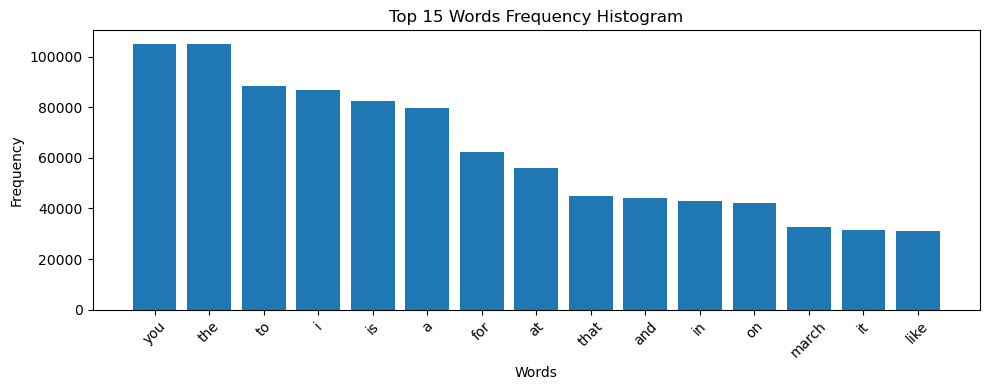

In [93]:
# lets have a look at the top 10 words
top_words = [word for word, count in word_freq.most_common(15)]
top_frequencies = [count for word, count in word_freq.most_common(15)]

# Create a bar plot for the top 5 words
plt.figure(figsize=(10,4))
plt.bar(top_words, top_frequencies)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 15 Words Frequency Histogram")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [94]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0
rev_word_map = {v: k for k, v in word_map.items()}

print(f"Total words are: {len(word_map)}")

Total words are: 7364


In [96]:
def encode_text(data, max_len):
    encoded_texts = []
    for utterance in data:
        utterance_words = utterance.lower().split()
        # Account for <start> and <end> tokens in max_len
        words = utterance_words[:(max_len-2)]  # -2 to make room for start/end
        # Add start and end tokens
        tokenized = [word_map['<start>']] + \
                [word_map.get(word, word_map['<unk>']) for word in words] + \
                [word_map['<end>']] + \
                [word_map['<pad>']] * (max_len - len(words) - 2)  # -2 for start/end
        encoded_texts.append(tokenized)
    return encoded_texts

In [ ]:
encoded_texts = encode_text(utterances_train, max_len = 100)
encoded_texts_test = encode_text(utterances_test, max_len = 100)

In [100]:
# test one sample
example_tokens = encoded_texts[0]
print(" ".join([rev_word_map[t] for t in example_tokens]))

<start> i am feeling hungry so i would like to find a place to eat <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


#### Dataset and Data Loaders

In [106]:
# Assuming label_train and label_test are lists of lists of indices
# Convert to one-hot encoding since it's multi-label (one utterance can have multiple acts)
num_classes = len(acts)

# Create one-hot encoded tensors
y_train = torch.zeros((len(label_train), num_classes))
for i, labels in enumerate(label_train):
    y_train[i, labels] = 1

y_test = torch.zeros((len(label_test), num_classes))
for i, labels in enumerate(label_test):
    y_test[i, labels] = 1

X_train = torch.tensor(encoded_texts)    # (number_of_samples, max_length)
X_test = torch.tensor(encoded_texts_test)

# Create datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=128,
                                         shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=128,
                                        shuffle=True)

RNN Network defined by:

$h_t= \tanh \left(W_h \cdot\left[h_{t-1}, x_t\right]+b_i\right)$ <br>

In [111]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz, num_classes):
        super(RNN, self).__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        self.num_classes = num_classes

        self.W_h = nn.Linear(input_sz + hidden_sz, hidden_sz)
        # Add output layer for multi-label classification
        self.output_layer = nn.Linear(hidden_sz, num_classes)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.size()

        h_t, c_t = (torch.zeros(batch_size, self.hidden_size).to(device),
                    torch.zeros(batch_size, self.hidden_size).to(device))

        hidden_states = []

        for t in range(seq_len):
            x_t = x[:, t, :]
            common_input = torch.cat([x_t, h_t], dim=-1)
            h_t = torch.tanh(self.W_h(common_input))
            hidden_states.append(h_t.unsqueeze(1))

        hidden_states = torch.cat(hidden_states, dim=1)
        
        # Use the final hidden state for classification
        final_hidden = hidden_states[:, -1, :]
        # Output logits for each class (don't apply sigmoid here)
        logits = self.output_layer(final_hidden)
        
        return logits

    def predict(self, x, threshold=0.5):
        """Helper method for inference"""
        logits = self.forward(x)
        probs = torch.sigmoid(logits)
        return (probs > threshold).float()

In [117]:
class Net(nn.Module):

    def __init__(self, input_embedding_size, hidden_size, num_classes):

        super().__init__()

        self.embedding = nn.Embedding(len(word_map), input_embedding_size)
        self.rnn = RNN(input_embedding_size, hidden_size, num_classes)

    def forward(self, x):

        # x is of shape (batch_size, max_seq_length)
        x = self.embedding(x)   # (batch_size, seq_len, embed_dim)
        x = self.rnn(x)        # (batch_size, seq_len, hidden_size)

        return x

In [119]:
# Initialize
model = Net(
    input_embedding_size=256,  # Your embedding dimension
    hidden_size=512,          # Hidden size of your choice
    num_classes=len(acts)   # Number of dialogue acts
).to(device)

# Loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Training loop example
optimizer = torch.optim.Adam(model.parameters())
epochs = 10

In [120]:
def train(epoch):
    model.train()
    train_loss = 0
    total = 0
    # For multi-label, we'll track f1 score instead of simple accuracy
    all_predictions = []
    all_targets = []
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Keep track of loss and predictions
        train_loss += loss.item()
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        total += targets.size(0)

    epoch_loss = train_loss / (batch_idx + 1)
    # Calculate micro-F1 score
    f1 = f1_score(np.array(all_targets), np.array(all_predictions), average='micro')
    
    print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_loss:.3f}, Train F1: {f1:.3f}')
    return epoch_loss, f1

# Testing
def test():
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss = test_loss / (batch_idx + 1)
    f1 = f1_score(np.array(all_targets), np.array(all_predictions), average='micro')
    
    print(f'Test Loss: {test_loss:.3f}, Test F1: {f1:.3f}')
    return test_loss, f1

# Inference on a single example
def inference_example(sample_idx=5):
    model.eval()
    sample = X_test[sample_idx].unsqueeze(0).to(device)
    
    # Get the original sentence
    sentence = ' '.join([rev_word_map[w] for w in X_test[sample_idx].tolist()])
    print(f'Input sentence: {sentence}')
    
    # Get predictions
    with torch.no_grad():
        output = model(sample)
        probs = torch.sigmoid(output)[0]
        predictions = (probs > 0.5).float()
        
    # Print all predicted acts with their probabilities
    print('\nPredicted dialogue acts:')
    for act_idx, (prob, is_predicted) in enumerate(zip(probs, predictions)):
        if is_predicted:
            act_name = inv_acts_labels[act_idx]
            print(f'{act_name}: {prob.item():.3f}')

# You'll need these imports
from sklearn.metrics import f1_score
import numpy as np

In [122]:
inference_example(5)

Input sentence: <start> sorry your reservation could not be made could i help you with something <end>

Predicted dialogue acts:
SYSTEM_INFORM: 0.903
SYSTEM_REQUEST: 0.894
CONFIRM: 0.943
OFFER: 0.892
NOTIFY_SUCCESS: 0.948
NOTIFY_FAILURE: 0.993
INFORM_COUNT: 0.956
OFFER_INTENT: 0.976
REQ_MORE: 0.962
SYSTEM_GOODBYE: 0.935
INFORM_INTENT: 0.882
NEGATE_INTENT: 0.981
AFFIRM_INTENT: 0.984
USER_INFORM: 0.774
USER_REQUEST: 0.867
AFFIRM: 0.907
NEGATE: 0.953
SELECT: 0.921
REQUEST_ALTS: 0.961
THANK_YOU: 0.914
USER_GOODBYE: 0.980


In [121]:
# Training
for epoch in range(epochs):
    train_loss, train_f1 = train(epoch)

# Testing
test_loss, test_f1 = test()

# Look at a single example
inference_example(5)

Epoch 0/10, Train Loss: 0.218, Train F1: 0.000
Epoch 1/10, Train Loss: 0.218, Train F1: 0.000


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss Curve')

In [ ]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Curve')

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

acc = 100.*correct/total
print('Test Accuracy: {:.3f}'.format(acc))

In [ ]:
sample = inputs[5]
sentence = ' '.join([rev_word_map[w] for w in sample.tolist()])
print(sentence)

output = model(sample.unsqueeze(0))
prob, pred = F.softmax(output, dim = -1).max(1)

print('index {} is predicted with a probability of {}'.format(pred.item(), prob.item()))
print('index {} is {}'.format(pred.item(), inv_categories_labels[pred.item()]))